In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

from utils.compl_cal import compl_mul, compl_div
from utils.PINNnet import sine_init, first_layer_sine_init, PINN
from utils.plot_func import plot_field, model_pred, plot_error_field, plot_loss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# fixed parameters
L, N = 1, 100
Lx, Ly = L, L
src = [0, 0]
k = 20

In [3]:
## hyperparameter
w = 100
n_in = 2 
n_out = 2
n_hiddens = 256
n_layers = 5
n_epochs = int(1e2)
learning_rate = 2e-5

In [4]:
## Dataset

def get_dataset(Lx, Ly, src, std=0.01, device=device):
    # pde
    x0, y0 = 2 * Lx * torch.rand(100000, 1) - Lx, 2 * Ly * torch.rand(100000, 1) - Ly
    r, theta = torch.linspace(0, 1, 200), torch.linspace(0, 2 * np.pi, 240)
    r, theta = torch.meshgrid(r, theta)
    r, theta = r.reshape(-1, 1), theta.reshape(-1, 1)
    x, y = r * torch.cos(theta) + src[0], r * torch.sin(theta) + src[1]
    x_min, x_max = -Lx, Lx
    y_min, y_max = -Ly, Ly
    mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
    x, y = x[mask].reshape(-1, 1), y[mask].reshape(-1, 1)
    x0[-len(r):, :], y0[-len(r):, :] = x, y
    f = 1 / (2 * np.pi * std ** 2) * torch.exp(-0.5 * (((x0 - src[0])/std)**2 + ((y0 - src[1])/std)**2))
    f = torch.cat([f, torch.zeros_like(f)], dim=-1)
    return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
            torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
             f.to(device)

def data_iter(batch_size, x, y, f):
    import random as rd
    num = len(f)
    ids = list(range(num))
    rd.shuffle(ids)
    for i in range(0, num, batch_size):
        batch_id = torch.tensor(ids[i:min(i + batch_size, num)])
        yield x[batch_id], y[batch_id], f[batch_id]

In [5]:
def get_PML_coefficient(x, y, L_pml, sigma0):
    dist_hor = torch.clamp(torch.abs(x) - (Lx - L_pml), min=0)
    dist_ver = torch.clamp(torch.abs(y) - (Ly - L_pml), min=0)
    sx = sigma0 * (dist_hor / L_pml) ** 2
    sy = sigma0 * (dist_ver / L_pml) ** 2
    ex = torch.cat([torch.ones_like(sx), sx], dim=-1)
    ey = torch.cat([torch.ones_like(sy), sy], dim=-1)
    return ex, ey

def loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5):
    x, y = x.reshape(-1, 1).to(device), y.reshape(-1, 1).to(device)
    x, y = x.requires_grad_(), y.requires_grad_()
    ex, ey = get_PML_coefficient(x, y, L_pml, sigma0)
    xy = torch.cat([x, y], dim=-1)

    p = model(xy)
    px_real = torch.autograd.grad(p[:, 0:1], x, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    px_imag = torch.autograd.grad(p[:, 1:2], x, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    px = compl_mul(compl_div(ey, ex), torch.cat([px_real, px_imag], dim=-1))
    pxx_real = torch.autograd.grad(px[:, 0:1], x, torch.ones_like(px[:, 0:1]), create_graph=True)[0]
    pxx_imag = torch.autograd.grad(px[:, 1:2], x, torch.ones_like(px[:, 1:2]), create_graph=True)[0]
    pxx = torch.cat([pxx_real, pxx_imag], dim=-1)
    py_real = torch.autograd.grad(p[:, 0:1], y, torch.ones_like(p[:, 0:1]), create_graph=True)[0]
    py_imag = torch.autograd.grad(p[:, 1:2], y, torch.ones_like(p[:, 1:2]), create_graph=True)[0]
    py = compl_mul(compl_div(ex, ey), torch.cat([py_real, py_imag], dim=-1))
    pyy_real = torch.autograd.grad(py[:, 0:1], y, torch.ones_like(py[:, 0:1]), create_graph=True)[0]
    pyy_imag = torch.autograd.grad(py[:, 1:2], y, torch.ones_like(py[:, 1:2]), create_graph=True)[0]
    pyy = torch.cat([pyy_real, pyy_imag], dim=-1)
    
    res = pxx + pyy + k**2 * compl_mul(compl_mul(ex, ey), p) - f
    del pyy, pxx
    return (res ** 2).mean()

In [6]:
new_train = True
if new_train:
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.apply(sine_init)
    model.net[0].apply(first_layer_sine_init)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []
else:
    import joblib
    state_dict = joblib.load('model_line.joblib')
    model = PINN(n_in, n_out, n_hiddens, n_layers).to(device)
    model.load_state_dict(state_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    l_lst = []

In [29]:
n_epochs = int(2e2)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [30]:
x0, y0, f0 = get_dataset(Lx, Ly, src)
model = model.to(device)
for epoch in tqdm(range(n_epochs)):
    if epoch == 1000:
        optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
    if epoch == 2000:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
    for x, y, f in data_iter(10000, x0, y0, f0):
        optimizer.zero_grad()
        loss_pde = loss_fn(model, x, y, src, k, f, L_pml=0.5, sigma0=5)
        loss = loss_pde
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 5 == 0: 
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
    l_lst.append(loss)

/tmp/ipykernel_16838/2472433537.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x0, dtype=torch.float32, requires_grad=False).to(device),\
/tmp/ipykernel_16838/2472433537.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y0, dtype=torch.float32, requires_grad=False).to(device),\
  2%|▎         | 5/200 [00:08<05:15,  1.62s/it]

Epoch 5, Loss: 0.006022288929671049


  5%|▌         | 10/200 [00:16<05:07,  1.62s/it]

Epoch 10, Loss: 0.0059129842557013035


  8%|▊         | 15/200 [00:24<05:00,  1.62s/it]

Epoch 15, Loss: 0.005713687278330326


 10%|█         | 20/200 [00:32<04:53,  1.63s/it]

Epoch 20, Loss: 0.005772738717496395


 12%|█▎        | 25/200 [00:40<04:46,  1.64s/it]

Epoch 25, Loss: 0.005722899455577135


 15%|█▌        | 30/200 [00:48<04:38,  1.64s/it]

Epoch 30, Loss: 0.005710010416805744


 18%|█▊        | 35/200 [00:56<04:31,  1.64s/it]

Epoch 35, Loss: 0.005792970769107342


 20%|██        | 40/200 [01:04<04:23,  1.65s/it]

Epoch 40, Loss: 0.005666194949299097


 22%|██▎       | 45/200 [01:13<04:15,  1.65s/it]

Epoch 45, Loss: 0.0055932896211743355


 25%|██▌       | 50/200 [01:21<04:08,  1.65s/it]

Epoch 50, Loss: 0.0056914580054581165


 28%|██▊       | 55/200 [01:29<04:00,  1.66s/it]

Epoch 55, Loss: 0.005593223962932825


 30%|███       | 60/200 [01:37<03:52,  1.66s/it]

Epoch 60, Loss: 0.005754272919148207


 32%|███▎      | 65/200 [01:45<03:44,  1.66s/it]

Epoch 65, Loss: 0.005501565523445606


 35%|███▌      | 70/200 [01:54<03:36,  1.66s/it]

Epoch 70, Loss: 0.005622363183647394


 38%|███▊      | 75/200 [02:02<03:28,  1.66s/it]

Epoch 75, Loss: 0.0056028044782578945


 40%|████      | 80/200 [02:10<03:19,  1.67s/it]

Epoch 80, Loss: 0.005517356563359499


 42%|████▎     | 85/200 [02:19<03:11,  1.67s/it]

Epoch 85, Loss: 0.005471346899867058


 45%|████▌     | 90/200 [02:27<03:05,  1.68s/it]

Epoch 90, Loss: 0.005490516312420368


 48%|████▊     | 95/200 [02:36<03:01,  1.73s/it]

Epoch 95, Loss: 0.005675227846950293


 50%|█████     | 100/200 [02:44<02:50,  1.70s/it]

Epoch 100, Loss: 0.005526237189769745


 52%|█████▎    | 105/200 [02:53<02:44,  1.73s/it]

Epoch 105, Loss: 0.005521882325410843


 55%|█████▌    | 110/200 [03:01<02:31,  1.69s/it]

Epoch 110, Loss: 0.005483870394527912


 57%|█████▊    | 115/200 [03:09<02:24,  1.70s/it]

Epoch 115, Loss: 0.0056344494223594666


 60%|██████    | 120/200 [03:18<02:16,  1.71s/it]

Epoch 120, Loss: 0.005511295981705189


 62%|██████▎   | 125/200 [03:26<02:09,  1.72s/it]

Epoch 125, Loss: 0.005588390398770571


 65%|██████▌   | 130/200 [03:36<02:07,  1.82s/it]

Epoch 130, Loss: 0.005587131250649691


 68%|██████▊   | 135/200 [03:44<01:54,  1.76s/it]

Epoch 135, Loss: 0.005579317919909954


 70%|███████   | 140/200 [03:53<01:44,  1.75s/it]

Epoch 140, Loss: 0.0054276189766824245


 72%|███████▎  | 145/200 [04:02<01:42,  1.86s/it]

Epoch 145, Loss: 0.005384885240346193


 75%|███████▌  | 150/200 [04:11<01:31,  1.83s/it]

Epoch 150, Loss: 0.005521107465028763


 78%|███████▊  | 155/200 [04:20<01:21,  1.82s/it]

Epoch 155, Loss: 0.005429053213447332


 80%|████████  | 160/200 [04:29<01:12,  1.82s/it]

Epoch 160, Loss: 0.005446837283670902


 82%|████████▎ | 165/200 [04:38<01:03,  1.82s/it]

Epoch 165, Loss: 0.005460966378450394


 85%|████████▌ | 170/200 [04:47<00:54,  1.81s/it]

Epoch 170, Loss: 0.0053417012095451355


 88%|████████▊ | 175/200 [04:56<00:45,  1.81s/it]

Epoch 175, Loss: 0.005305314902216196


 90%|█████████ | 180/200 [05:05<00:36,  1.82s/it]

Epoch 180, Loss: 0.005397959612309933


 92%|█████████▎| 185/200 [05:14<00:27,  1.82s/it]

Epoch 185, Loss: 0.005279285367578268


 95%|█████████▌| 190/200 [05:23<00:18,  1.82s/it]

Epoch 190, Loss: 0.0053392923437058926


 98%|█████████▊| 195/200 [05:33<00:09,  1.88s/it]

Epoch 195, Loss: 0.005426623392850161


100%|██████████| 200/200 [05:42<00:00,  1.71s/it]

Epoch 200, Loss: 0.005389347206801176


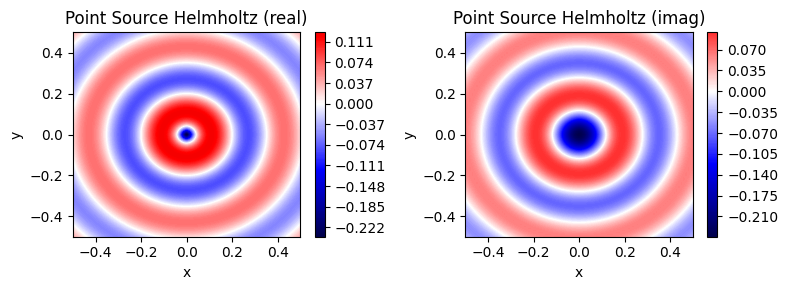

In [26]:
model_pred(model, 0.5, 0.5)

In [28]:
import joblib
joblib.dump(model.state_dict(), 'model_line.joblib')

['model_line.joblib']

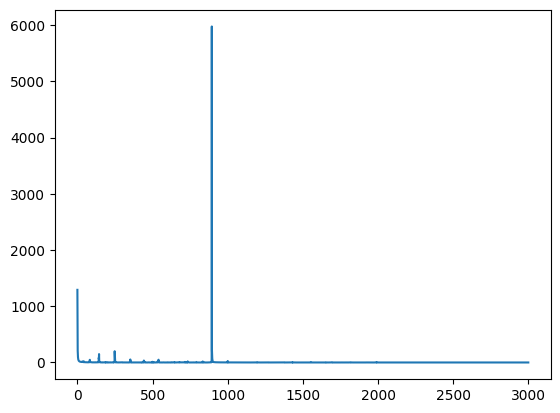

In [23]:
i = 0
loss_list = []
for loss in l_lst:
    loss_list.append(loss.to('cpu').detach().numpy())
np.save('loss.npy', loss_list)
plot_loss(l_lst)

Error(Real) -0.009423046372830868, Error(Imag) -0.022477559745311737


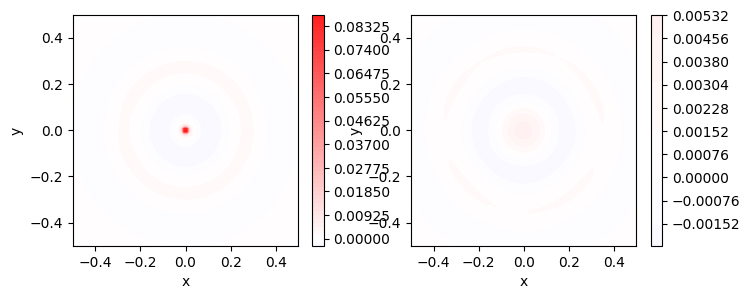

In [27]:
x, y = torch.linspace(-0.5, 0.5, N), torch.linspace(-0.5, 0.5, N)
x, y = torch.meshgrid(x, y)
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
model = model.to('cpu')
inputs = torch.cat([x, y], dim=-1)
p_real = model(inputs)[:, 0].detach().numpy()
p_imag = model(inputs)[:, 1].detach().numpy()
p_real, p_imag = p_real.reshape(N, N), p_imag.reshape(N, N)

x, y = x.numpy(), y.numpy()
hankel = scipy.special.hankel1(0, k * np.sqrt(x ** 2 + y ** 2) + 1e-6)
p_ref = - 0.25j * hankel
p_ref_real, p_ref_imag = p_ref.real.reshape(N, N), p_ref.imag.reshape(N, N)

error_real = p_real - p_ref_real
error_imag = p_imag - p_ref_imag

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_real, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
p_max = 0.2
cmap = matplotlib.cm.seismic
norm = matplotlib.colors.Normalize(vmin=-p_max, vmax=p_max)
plt.contourf(x.reshape(N, N), y.reshape(N, N), error_imag, levels=400, cmap=cmap, origin='lower', norm=norm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
print(f"Error(Real) {error_real.mean() / p_ref_real.mean()}, Error(Imag) {error_imag.mean() / p_ref_imag.mean()}")